# Efficient moving obstacle constraint adding when doing MILP planning

In [12]:
import sys
sys.path.append('../')
from panav.env import NavigationEnv, Box2DRegion, box_2d_center, PolygonRegion
from panav.hybrid import HybridGraph
from panav.viz import draw_hybrid

from panav.TrafficAwarePlanning import traffic_aware_HG_plan
from panav.SAMP import Tube_Planning

import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Empty environment

In [8]:

# 2D navigation environment

start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

top, bottom = 8,-8
start_x_offset = 6
goal_x_offset = 8
N = 1

start_locs = np.vstack([
np.vstack([np.ones(N)*start_x_offset,np.linspace(top,bottom, N)]).T,
np.vstack([np.ones(N)*(-start_x_offset),np.linspace(top,bottom, N)]).T])

goal_locs = np.vstack([
np.vstack([np.ones(N)*(-goal_x_offset),np.linspace(bottom,top, N)]).T,
np.vstack([np.ones(N)*goal_x_offset,np.linspace(bottom,top, N)]).T])


starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

start = np.array(list(starts[0].centroid().coords)[0])
goal = np.array(list(goals[0].centroid().coords)[0])

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 
env = NavigationEnv(limits,[],starts,goals)

# Multi-tunnel Environment

In [21]:
y_min,y_max = min(limits[1]),max(limits[1])
n_tunnel = 1
w = 2*bloating_r # Tunnel width
s = (y_max-y_min-w*n_tunnel)/(n_tunnel+1) # Spacing between tunnels

d = 5 # Thickness of the wall

obstacles = []
for i in range(n_tunnel+1):
    side = np.array([d,s])
    center = np.array([0, y_max-s/2-i*(s+w)])
    obstacles.append(box_2d_center(center,side))
env.obstacles = obstacles



/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


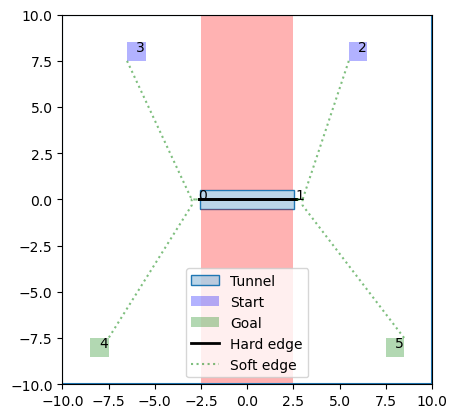

In [22]:
HG = HybridGraph(env,bloating_r)
ax = plt.gca()
draw_hybrid(HG,ax,display_soft=True,display_node=True)
plt.show()    

In [23]:
paths = traffic_aware_HG_plan(HG)

In [84]:
import cvxpy as cp

In [115]:
v1 = cp.Variable((2,2),boolean=True)
v2 = cp.Variable((3,4),boolean=True)

In [116]:
prob = cp.Problem(cp.Minimize(v1[0,0]+v2[0,1]))

In [121]:
from panav.util import unique_tx
start0 = HG.node_loc(paths[0][0])
goal0 = HG.node_loc(paths[0][-1])

start1 = HG.node_loc(paths[1][0])
goal1 = HG.node_loc(paths[1][-1])

vmax = 1.0
obstacle_traj = []
p0 = Tube_Planning(HG.env,start0,goal0,vmax,bloating_r,K=4)
p0 = unique_tx(*p0)
obstacle_traj.append(p0)

number of integer constraints: 32


In [122]:
from panav.SAMP import lazy_optim

planner = lambda env,start,goal,moving_obstacles: Tube_Planning(env,start,goal,vmax,bloating_r, moving_obstacles)
p1 = lazy_optim(planner,HG.env,start1,goal1,obstacle_traj,bloating_r)
obstacle_traj.append(p1)

num obstacle trajectories:0/1
number of integer constraints: 80
num obstacle trajectories:1/1
number of integer constraints: 490


/Users/tianpengzhang/Dropbox (Harvard University)/Tianpeng's research/Tianpeng & Lina/Multiagent Motion Planning/PA-Nav/notebooks_playground/../panav/conflict.py:90: RuntimeWarning: invalid value encountered in divide
  va = (pa[:,1]-pa[:,0])/(ta[1]-ta[0])
/Users/tianpengzhang/Dropbox (Harvard University)/Tianpeng's research/Tianpeng & Lina/Multiagent Motion Planning/PA-Nav/notebooks_playground/../panav/conflict.py:90: RuntimeWarning: divide by zero encountered in divide
  va = (pa[:,1]-pa[:,0])/(ta[1]-ta[0])
/Users/tianpengzhang/Dropbox (Harvard University)/Tianpeng's research/Tianpeng & Lina/Multiagent Motion Planning/PA-Nav/notebooks_playground/../panav/conflict.py:101: RuntimeWarning: invalid value encountered in add
  return np.linalg.norm(u + lb * v)<= ra+rb \
/Users/tianpengzhang/Dropbox (Harvard University)/Tianpeng's research/Tianpeng & Lina/Multiagent Motion Planning/PA-Nav/notebooks_playground/../panav/conflict.py:102: RuntimeWarning: invalid value encountered in add
  or np

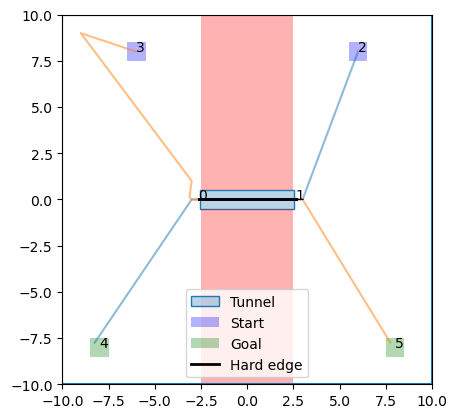

In [81]:
draw_hybrid(HG,ax=plt.gca(),paths = [o[1] for o in obstacle_traj])